In [10]:
from maze import Maze, test_agent,plot_cost_to_go,plot_max_q,seed_everything,plot_stats
import gym
import torch
import matplotlib.pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm
import os

In [2]:
env = gym.make('CartPole-v0')

c:\Users\hebli\anaconda3\envs\env1\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


In [6]:
dims = env.observation_space.shape[0]
actions = env.action_space.n 
print(f'State dimensions: {dims}. Actions: {actions}')
print(f'Sample state: {env.reset()}')

State dimensions: 4. Actions: 2
Sample state: [ 0.00770742  0.02144871  0.02658538 -0.0218952 ]


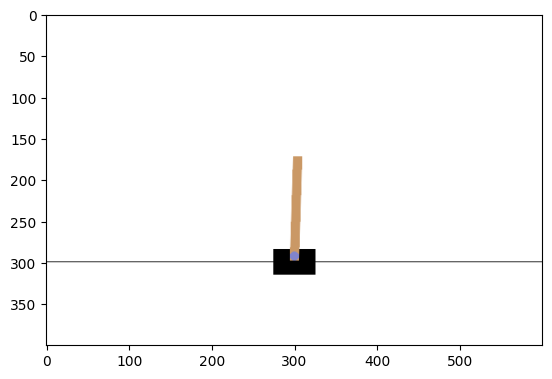

In [8]:
plt.imshow(env.render(mode='rgb_array'))

In [9]:
class PreprocessEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    
    def reset(self):
        state = self.env.reset()
        return torch.from_numpy(state).float()
    
    def step(self, actions):
        actions = actions.squeeze().numpy()
        next_state, reward, done, info = self.env.step(actions)
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1)
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [11]:
num_envs = os.cpu_count()
parellel_env = gym.vector.make('CartPole-v1', num_envs = num_envs)
seed_everything(parellel_env)
parellel_env = PreprocessEnv(parellel_env)


In [12]:
parellel_env.reset()

tensor([[ 0.0274, -0.0061,  0.0359,  0.0197],
        [ 0.0152, -0.0456, -0.0480,  0.0339],
        [-0.0377, -0.0242, -0.0094,  0.0469],
        [ 0.0073,  0.0028,  0.0264,  0.0312],
        [ 0.0406, -0.0423, -0.0227,  0.0122],
        [ 0.0242,  0.0254, -0.0035, -0.0396],
        [-0.0112,  0.0096,  0.0014,  0.0194],
        [-0.0137,  0.0093, -0.0108,  0.0124]])

In [13]:
policy = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64, actions),
    nn.Softmax(dim = -1)
)

In [14]:
neutral_state = torch.zeros(4)
left_danger = torch.tensor([-2.3, 0., 0., 0.])
right_danger = torch.tensor([2.3, 0., 0., 0.])

In [15]:
import numpy as np
def plot_action_probs(probs, labels):
    x = np.arange(len(probs)) 
    plt.bar(x, probs, color='skyblue', alpha=0.7)
    plt.xticks(x, labels)
    plt.ylabel('Probability')
    plt.title('Action Probabilities')
    for i, prob in enumerate(probs):
        plt.text(i, prob + 0.01, f'{prob:.2f}', ha='center', fontsize=12)
    
    plt.ylim(0, 1.1)  
    plt.show()

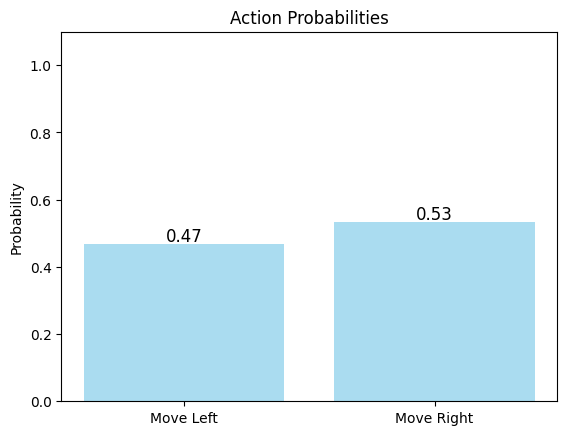

In [16]:
probs = policy(neutral_state).detach().numpy()
plot_action_probs(probs = probs, labels = ['Move Left', 'Move Right'])

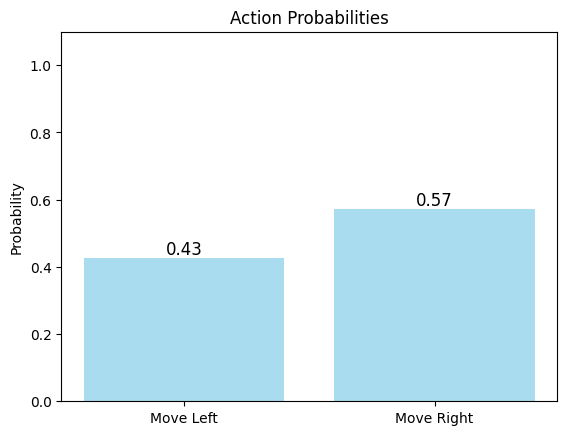

In [17]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs = probs, labels = ['Move Left', 'Move Right'])

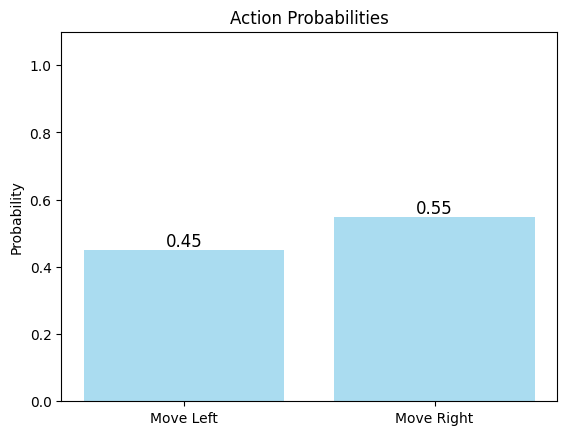

In [18]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs = probs, labels = ['Move Left', 'Move Right'])

In [19]:
def reinforce(policy, episodes, alpha = 1e-4, gamma = 0.99):
    optim = AdamW(policy.parameters(), lr = alpha)
    stats = {'PG Loss':[], 'Returns':[]}

    for episode in tqdm(range(1, episodes+1)):
        state = parellel_env.reset()
        done_b = torch.zeros((num_envs,1), dtype = torch.bool)
        transitions = []
        ep_return = torch.zeros((num_envs,1))

        while not done_b.all():
            action = policy(state).multinomial(1).detach()
            next_state, reward, done, _ = parellel_env.step(action)
            transitions.append([state,action, ~done_b*reward])
            ep_return += reward
            done_b |= done
            state = next_state
        G = torch.zeros((num_envs,1))
        for t, (state_t, action_t, reward_t) in reversed(list(enumerate(transitions))):
            G = reward_t + gamma * G
            probs_t = policy(state_t)
            log_probs_t = torch.log(probs_t + 1e-6)
            action_log_prob_t = log_probs_t.gather(1, action_t)

            entropy_t = -torch.sum(probs_t*log_probs_t, dim = -1, keepdim = True)
            gamma_t = gamma**t
            pg_loss_t = - gamma_t*action_log_prob_t*G
            total_loss_t = (pg_loss_t-0.01* entropy_t).mean()
            policy.zero_grad()
            total_loss_t.backward()
            optim.step()

        stats['PG Loss'].append(total_loss_t.item())
        stats['Returns'].append(ep_return.mean().item())

    return stats

In [20]:
stats = reinforce(policy, 200)

100%|██████████| 200/200 [02:36<00:00,  1.28it/s]


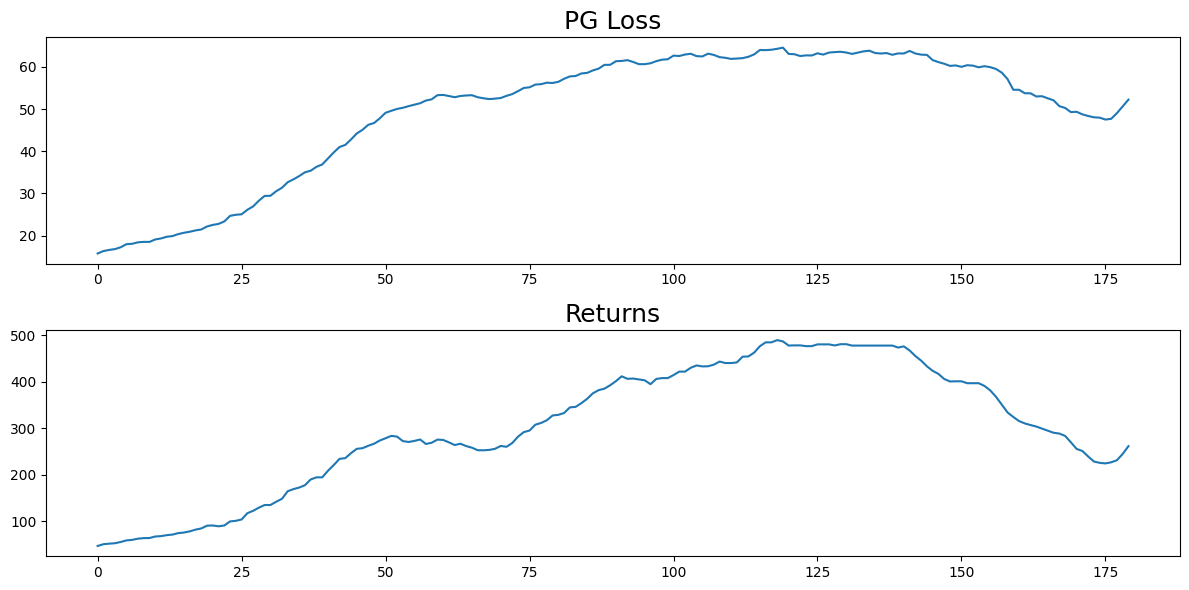

In [21]:
plot_stats(stats)

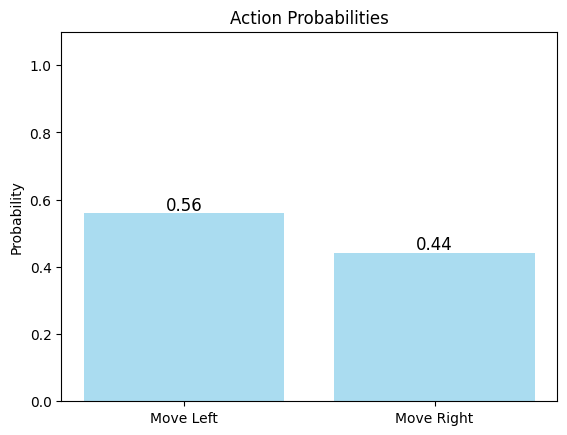

In [22]:
probs = policy(neutral_state).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

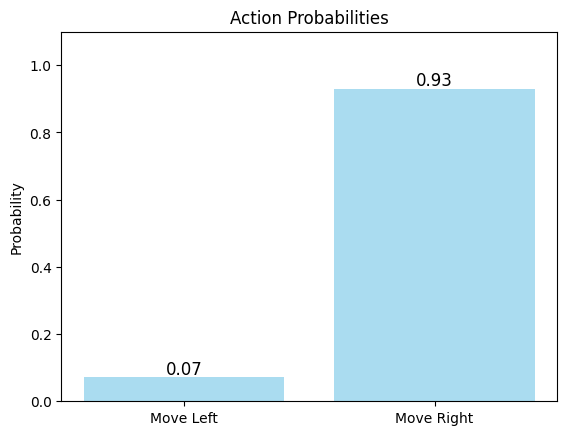

In [23]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

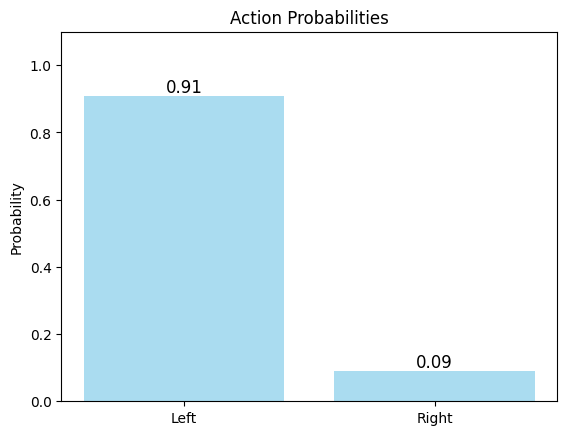

In [24]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Left', 'Right'])

In [27]:
from typing import Tuple, Dict, Optional, Iterable, Callable

import numpy as np
import seaborn as sns
import matplotlib
import torch
from matplotlib import animation
import matplotlib.patches as mpatches

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw

def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

def test_policy_network(env, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            state = torch.from_numpy(state).unsqueeze(0).float()
            action = policy(state).multinomial(1).item()
            next_state, _, done, _ = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)


def plot_action_probs(probs, labels):
    plt.figure(figsize=(6, 4))
    plt.bar(labels, probs, color ='orange')
    plt.title("$\pi(s)$", size=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

In [29]:
test_policy_network(env, policy, episodes=5)

C:\Users\hebli\AppData\Local\Temp\ipykernel_4424\2514848222.py:24: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use(orig_backend)
